In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline
from numpy.polynomial.polynomial import Polynomial
import warnings
warnings.filterwarnings("ignore")



This project is to design mathematical model against historical population related data for over 200 countries from 1970 to 2022 to forecast the future population issue.

# Data Analysis and Trend Identification

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("world_population.csv")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Rank                           0
CCA3                           0
Country/Territory              0
Capital                        0
Continent                      0
2022 Population                0
2020 Population                0
2015 Population                0
2010 Population                0
2000 Population                0
1990 Population                0
1980 Population                0
1970 Population                0
Area (km²)                     0
Density (per km²)              0
Growth Rate                    0
World Population Percentage    0
dtype: int64


In [3]:
# Calculate average annual growth rate for each country
growth_rates = []
for i, row in df.iterrows(): 
    p0 = row["1970 Population"]
    p1 = row["2022 Population"]
    t0 = 1970
    t1 = 2022
    if p0 > 0:
        r = (p1 / p0) ** (1 / (t1 - t0)) - 1
    else:
        r = np.nan
    growth_rates.append(r)

df["Average Annual Growth Rate"] = growth_rates # Add the AAGR to each row

# Classification function
def classify_growth(r):
    if r > 0.02:
        return "Rapid Growth"
    elif r > 0.01:
        return "Moderate Growth"
    elif r > 0:
        return "Slow Growth"
    elif r > -0.005:
        return "Stable"
    else:
        return "Declining"

df["Growth Category"] = df["Average Annual Growth Rate"].apply(classify_growth)

# Count the number of countries in each category
category_counts = df["Growth Category"].value_counts()
print("Number of countries in each growth category:")
print(category_counts)


Number of countries in each growth category:
Growth Category
Rapid Growth       91
Slow Growth        64
Moderate Growth    64
Stable             12
Declining           3
Name: count, dtype: int64


Correlation between growth rate and population density: -0.01


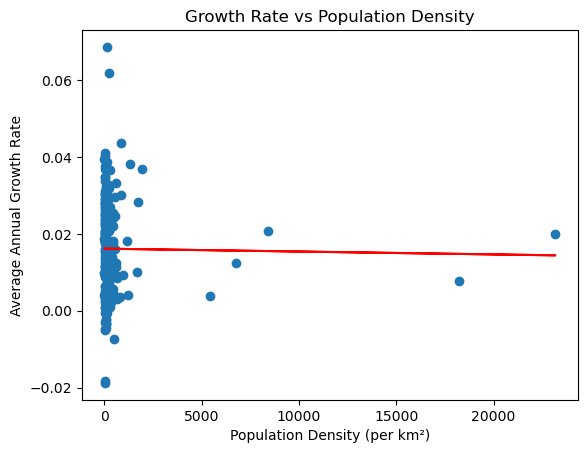

In [4]:
# Correlation between growth rate and population density
corr_density = df["Density (per km²)"].corr(df["Average Annual Growth Rate"])
print(f"Correlation between growth rate and population density: {corr_density:.2f}")

x = df["Density (per km²)"]
y = df["Average Annual Growth Rate"]
coeffs = np.polyfit(x, y, 1)
poly_fn = np.poly1d(coeffs)

# Scatter plot of growth rate vs. population density
plt.scatter(x, y)
plt.plot(x, poly_fn(x), color='red', label="Trend Line")
plt.xlabel("Population Density (per km²)")
plt.ylabel("Average Annual Growth Rate")
plt.title("Growth Rate vs Population Density")
plt.show()


Correlation between growth rate and land area: -0.02


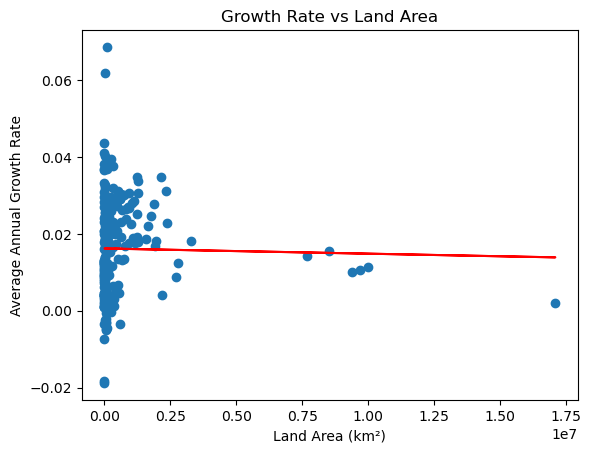

In [5]:
# Correlation between growth rate and land area
corr_area = df["Area (km²)"].corr(df["Average Annual Growth Rate"])
print(f"Correlation between growth rate and land area: {corr_area:.2f}")

# Scatter plot of growth rate vs. land area

x = df["Area (km²)"]
y = df["Average Annual Growth Rate"]
coeffs = np.polyfit(x, y, 1)
poly_fn = np.poly1d(coeffs)

plt.scatter(x, y)
plt.plot(x, poly_fn(x), color='red', label="Trend Line")
plt.xlabel("Land Area (km²)")
plt.ylabel("Average Annual Growth Rate")
plt.title("Growth Rate vs Land Area")
plt.show()


Correlation between growth rate and land area: 0.01


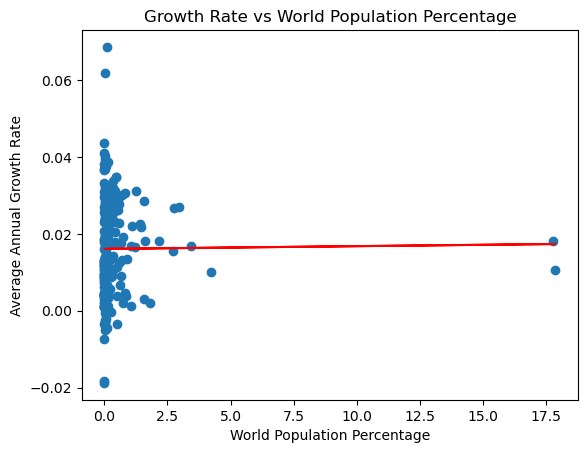

In [6]:
# Correlation between growth rate and land area
corr_area = df["World Population Percentage"].corr(df["Average Annual Growth Rate"])
print(f"Correlation between growth rate and land area: {corr_area:.2f}")

# Scatter plot of growth rate vs. land area
x = df["World Population Percentage"]
y = df["Average Annual Growth Rate"]
coeffs = np.polyfit(x, y, 1)
poly_fn = np.poly1d(coeffs)

plt.scatter(x, y)
plt.plot(x, poly_fn(x), color='red', label="Trend Line")

plt.xlabel("World Population Percentage")
plt.ylabel("Average Annual Growth Rate")
plt.title("Growth Rate vs World Population Percentage")
plt.show()



In [7]:
# Average growth rate by continent
continent_growth = df.groupby("Continent")["Average Annual Growth Rate"].mean().sort_values(ascending=False)
print("Average annual growth rate by continent:")
print(continent_growth)


Average annual growth rate by continent:
Continent
Africa           0.025956
Asia             0.021304
South America    0.015516
North America    0.013257
Oceania          0.012097
Europe           0.004136
Name: Average Annual Growth Rate, dtype: float64


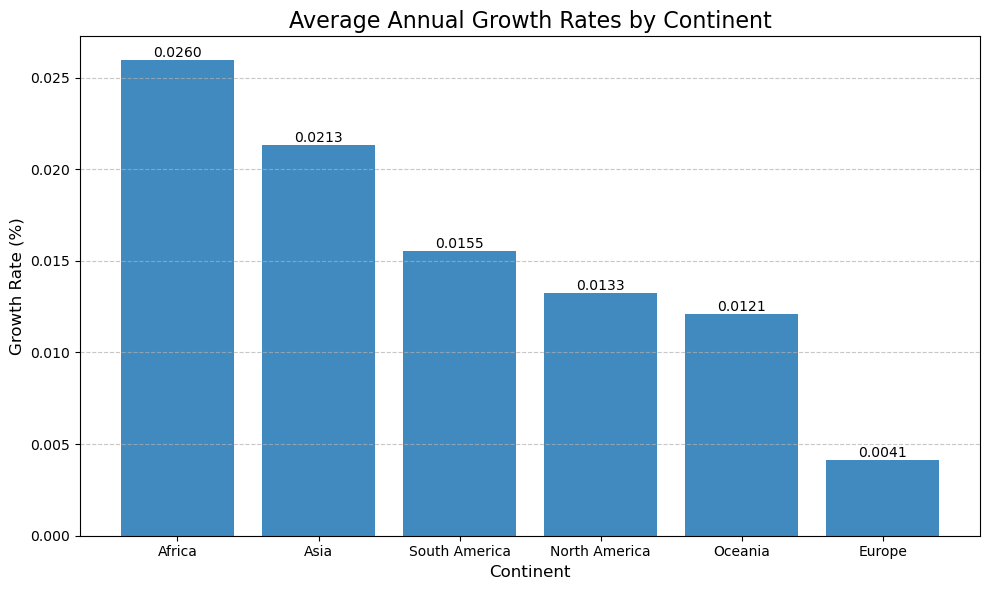

In [8]:
import matplotlib.pyplot as plt

# Data for the continents and their growth rates
dict1 = continent_growth.to_dict()

continents = list(dict1.keys()) #['Africa', 'Asia', 'South America', 'North America', 'Oceania', 'Europe']
growth_rates = list(dict1.values()) #[2.60, 2.13, 1.55, 1.33, 1.21, 0.41]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(continent_growth.index, continent_growth.values,color='#6699cc', alpha=0.7)
plt.title("Average Annual Growth Rates by Continent", fontsize=16)
plt.xlabel("Continent", fontsize=12)
plt.ylabel("Growth Rate (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
bars = plt.bar(continent_growth.index, continent_growth.values, alpha=0.7)

# 添加数字标签
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # 水平位置
        bar.get_height(),  # 垂直位置
        f'{bar.get_height():.4f}',  # 格式化标签为小数点后四位
        ha='center',  # 水平居中
        va='bottom',  # 垂直位置靠下
        fontsize=10  # 字体大小
    )
# Show the chart
plt.tight_layout()
plt.show()

# Model Development

After conducting initial analyses to visualize global population trends, we are tasked with forecasting population growth in various countries. Typically, the population growth among countries can be categorized into two types: One with logistic growth (Verhulst, 1838) , population increases until it stabilizes at a certain level; One with exponential decay (Cohen, 2003), describing a process where population decrease until it stabilizes. 

However, there would be cases where logistic models & exponetial decay models fail to converge. Hyndman and Booth (2008) proved that polynomial model would be a reliable model in addressing complex growth patterns for their flexibility.

So, the final model would be suitable for 3 categories of countries:

1) Logistic Growth Model: $$ P(t) = \frac{K}{1 + e^{-r(t-t_0)}} $$


2. Exponential Decay Model: $$ P(t) = P_0 \cdot \exp(-r \cdot (t - t_0)) + C $$

3. Polynomial Regression Model (when logistic growth does not fit): $$ P(t) = a_0 + a_1 t + a_2 t^2 + \cdots + a_n t^n $$


In [23]:
# Define the logistic function
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

# Define the modified exponential decay function with baseline population
def exponential_decay_with_baseline(t, P0, r, t0, C):
    return P0 * np.exp(-r * (t - t0)) + C

# Define years for training and validation
years = np.array([1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022])
tv_idx = 5  # Training data ends at 2010

# Initialize lists to store results
error_list = []
params_list = []
countries_failed = []

# Store Labels
value_error = []
missing_data = []
insufficient_pts = []
runtimeError_lst = []
poly_failed = []

decay_model = []
logistic_model = []
poly_model = []

# Iterate through countries in the dataset
for i, row in df.iterrows():
    # Extract population data and ensure numerical type
    try:
        populations = row[[f"{year} Population" for year in years]].values.astype(float)
    except ValueError as e:
        # print(f"Data conversion error for {row['Country/Territory']}: {e}")
        value_error.append(row['Country/Territory'])
        continue
    
    # Split data into training and validation sets
    y_train = years[:tv_idx]
    p_train = populations[:tv_idx]
    y_valid = years[tv_idx:]
    p_valid = populations[tv_idx:]
    
    # Handle missing or invalid data
    if any(np.isnan(p_train)) or any(np.isnan(p_valid)):
        # print(f"Missing data for {row['Country/Territory']}")
        countries_failed.append(row["Country/Territory"])
        missing_values.append(row["Country/Territory"])
        continue

    # Roughly Detect declining trend
    is_declining = populations[-1] < populations[-2] and populations[-2] < populations[-3] 

    if is_declining:
        # Use modified exponential decay model for declining trend
        # print(f"{row['Country/Territory']} detected as declining, using exponential decay model with baseline.")

        try:
            # Extract only declining data points
            decline_years = []
            decline_populations = []
            for j in range(1, len(populations)):
                if populations[j] < populations[j - 1]:
                    decline_years.append(years[j])
                    decline_populations.append(populations[j])

            # Ensure enough points for fitting
            if len(decline_years) < 3:
                # print(f"Insufficient declining points for {row['Country/Territory']}, switching to fallback.")
                params_list.append([np.nan, np.nan, np.nan, np.nan])
                error_list.append(np.nan)
                countries_failed.append(row["Country/Territory"])
                insufficient_pts.append(row["Country/Territory"])
                continue   # Drawback1: Some data points may have larger declining numbers but not fit decay model
            else: 
            # Convert to numpy arrays
                decline_years = np.array(decline_years)
                decline_populations = np.array(decline_populations)

                # Initial guesses for exponential decay parameters
                P0 = decline_populations[0]  # Initial population that starts to decline
                r0 = 0.05  # Reduced initial decay rate
                t0_0 = decline_years[0]  # Start of decline
                C0 = decline_populations[-1] * 0.5  # Baseline as 50% of last point (more smoothing)

                # Fit the exponential decay model with baseline
                popt, _ = curve_fit(
                    exponential_decay_with_baseline,
                    decline_years,
                    decline_populations,
                    p0=[P0, r0, t0_0, C0],
                    bounds=(
                        [0, 0.01, decline_years.min(), decline_populations[-1] * 0.2],  # Lower bounds
                        [np.inf, 0.2, decline_years.max(), decline_populations[-1] * 0.8]  # Upper bounds
                    ),
                    maxfev=10000
                )
                params_list.append(popt)

                # Predict and calculate error for the decline points
                pred = exponential_decay_with_baseline(decline_years, *popt)
                error = np.sqrt(np.mean((pred - decline_populations) ** 2)) / decline_populations[0]
                error_list.append(error)
                decay_model.append(row["Country/Territory"])
            
        except RuntimeError as e:
            #print(f"Exponential decay model failed for {row['Country/Territory']}: {e}")
            params_list.append([np.nan, np.nan, np.nan, np.nan])
            error_list.append(np.nan)
            countries_failed.append(row["Country/Territory"])
            runtimeError_lst.append(row["Country/Territory"])
            

    else:
        # Attempt to fit logistic model for non-declining countries
        K0 = max(p_train) * 1.5
        r0 = 0.02
        t0_0 = y_train[len(y_train)//2]

        try:
            popt, _ = curve_fit(logistic, y_train, p_train, p0=[K0, r0, t0_0], maxfev=10000)
            params_list.append(popt)
            
            # Predict and calculate error for validation data
            pred = logistic(y_valid, *popt)
            error = np.sqrt(np.mean((pred - p_valid) ** 2)) / p_train[-1]
            error_list.append(error)
            logistic_model.append(row["Country/Territory"])

        except RuntimeError:
            # If logistic fit fails, fallback to polynomial regression
            # print(f"Logistic model failed for {row['Country/Territory']}, using polynomial model.")
            countries_failed.append(row["Country/Territory"])
            
            try:
                # Fit a polynomial model (degree 2 or 3)
                poly_deg = 3  # You can adjust this degree ： It needs to be well ceritified, why 3 is the best?
            
                poly = Polynomial.fit(y_train, p_train, deg=poly_deg)
                
                # Store polynomial coefficients
                params_list.append(poly.convert().coef.tolist())
                # print(poly.convert().coef.tolist())
                # Predict using polynomial model and calculate error
                pred = poly(y_valid)
                error = np.sqrt(np.mean((pred - p_valid) ** 2)) / p_train[-1]
                error_list.append(error)
                poly_model.append(row["Country/Territory"])
            except Exception as e:
                #print(f"Polynomial fit failed for {row['Country/Territory']}: {e}")
                params_list.append([np.nan] * (poly_deg + 1))
                error_list.append(np.nan)
                poly_failed.append(row["Country/Territory"])


# Summarize results
df["RMSE"] = error_list
df["Model Parameters"] = params_list



In [24]:
# Revise the output of the answer
def print_list(k):
    if len(k) == 0:
        return None
    else:
        return k
    
print(f"Countries that contains error population data that can't be converted into floats: {print_list(value_error)}\n")
print(f"Countries that contains missing population data: {print_list(missing_data)}\n")
print(f"Countries that have insufficient declining points that does not fit decaying model: {print_list(insufficient_pts)}\n")
print(f"Countries that exponential decay model failed due to time error: {print_list(runtimeError_lst)}\n")

##print(f"Number of countries where logistic fit failed: {len(countries_failed)}")
##print("Countries where fallback polynomial model was used:")
##print_list(countries_failed)

print(f"Number of countries using Logistic Model: {len(logistic_model)}")
print(f"Countries using Logistic Model: {print_list(logistic_model)}\n")

print(f"Number of countries using Decay Model: {len(decay_model)}")
print(f"Countries using Exponential Decay Model: {print_list(decay_model)}\n")

print(f"Number of countries using Polynomial Model: {len(poly_model)}")
print(f"Countries using Polynomial Regression Model: {print_list(poly_model)}\n")

print(f"Number of countries failed with Polynomial Model: {len(poly_failed)}")
print(f"Countries that polynomial model failed: {print_list(poly_failed)}\n")

Countries that contains error population data that can't be converted into floats: None

Countries that contains missing population data: None

Countries that have insufficient declining points that does not fit decaying model: ['Cuba', 'Italy', 'Lebanon', 'Venezuela']

Countries that exponential decay model failed due to time error: ['Montenegro', 'Portugal']

Number of countries using Logistic Model: 190
Countries using Logistic Model: ['Afghanistan', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belgium', 'Belize', 'Bermuda', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Curacao', 'Cyprus', 'Czech Republic', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador

# Regional Comparison

After the model is set, we need to use the model to predict populations and do regional comparisons. 

In [22]:
import numpy as np
from numpy.polynomial import Polynomial

future_years = np.arange(2022, 2051, 5)  # e.g., predictions for 2022 to 2050 in 5-year steps

# Prepare an array/list to store predictions for each country
predictions = []

for idx, row in df.iterrows():
    country = row["Country/Territory"]
    popt = params_list[idx]

    # Handle cases where no valid model was fit (NaN parameters)
    if np.isnan(popt).any():
        # Use the last known population as a constant prediction
        last_pop = row[f"{years[-1]} Population"]
        pred = np.full_like(future_years, last_pop, dtype=float)
        predictions.append(pred)
        continue

    # Distinguish the model by which list the country is in
    if country in logistic_model:
        # -- Logistic model --
        pred = logistic(future_years, *popt)
        # Adjust to connect to the last historical data point
        last_pop = row[f"{years[-1]} Population"]
        pred_last = logistic(years[-1], *popt)
        adjustment = last_pop - pred_last
        pred += adjustment
        predictions.append(pred)

    elif country in decay_model:
        # -- Exponential decay model --
        pred = exponential_decay_with_baseline(future_years, *popt)
        # Adjust to connect to the last historical data point
        last_pop = row[f"{years[-1]} Population"]
        pred_last = exponential_decay_with_baseline(years[-1], *popt)
        adjustment = last_pop - pred_last
        pred += adjustment
        predictions.append(pred)

    elif country in poly_model:
        # -- Polynomial model --
        poly = Polynomial(popt)  # Reconstruct polynomial from coefficients
        pred = poly(future_years)
        # Adjust to connect to the last historical data point
        last_pop = row[f"{years[-1]} Population"]
        pred_last = poly(years[-1])
        adjustment = last_pop - pred_last
        pred += adjustment
        predictions.append(pred)

    else:
        print(f"No recognized model for {country}. Using constant population fallback.")
        last_pop = row[f"{years[-1]} Population"]
        pred = np.full_like(future_years, last_pop, dtype=float)
        predictions.append(pred)

# Convert list of arrays to a numpy array for convenience
predictions = np.array(predictions)
# Calculate average relative RMSE
error_array = np.array(error_list, dtype=np.float64)
average_rmse = np.nanmean(error_array) # Using test set 
print(f"Average relative RMSE: {average_rmse * 100:.2f}%")


Average relative RMSE: 6.69%


RMSE is 6.69%，indicates that the models used are reliable for long-term forecasting.

In [25]:
# List of continents
continents = df["Continent"].unique()

# Dictionary to store continent-wise predictions
continent_predictions = {}

for continent in continents:
    idx = df[df["Continent"] == continent].index
    preds_continent = predictions[idx, :]
    sum_preds = preds_continent.sum(axis=0)
    continent_predictions[continent] = sum_preds
# Calculate historical global population
global_population_history = df[[f"{year} Population" for year in years]].sum().values

# Calculate global population predictions
global_population_predictions = predictions.sum(axis=0)


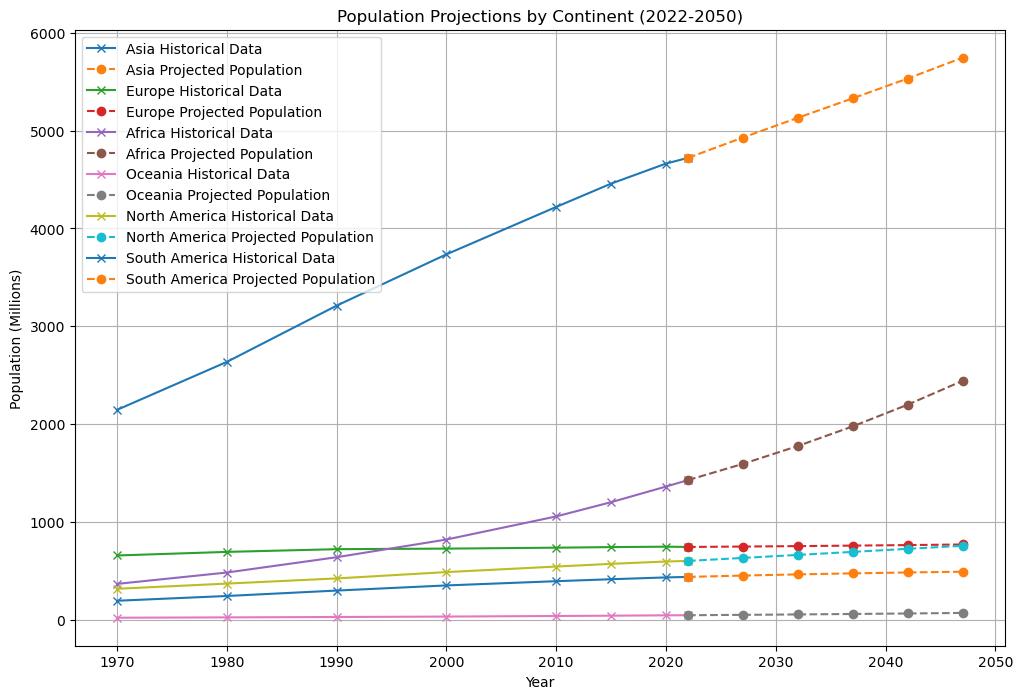

In [26]:
continent_historical = {}

for continent in continents:
    idx = df[df["Continent"] == continent].index
    historical_pops = df.iloc[idx][[f"{year} Population" for year in years]].sum().values
    continent_historical[continent] = historical_pops

plt.figure(figsize=(12, 8))

for continent in continents:
    plt.plot(years, continent_historical[continent] / 1e6, marker="x", linestyle='-', label=f"{continent} Historical Data")
    plt.plot(future_years, continent_predictions[continent] / 1e6, marker="o", linestyle='--', label=f"{continent} Projected Population")

plt.xlabel("Year")
plt.ylabel("Population (Millions)")
plt.title("Population Projections by Continent (2022-2050)")
plt.legend()
plt.grid(True)
plt.show()


# Visualization

To better illustrate the model predictions, we are asked to visualize the key findings by illustrative graphs and explanations.

### Global Population Projection

The estimated population at 2050: 9828467289.324482


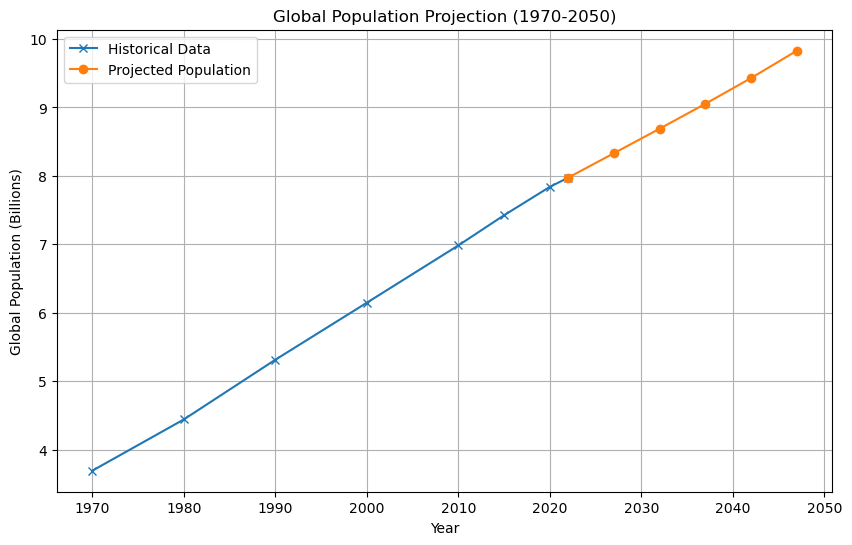

In [14]:

# List of continents
continents = df["Continent"].unique()

# Dictionary to store continent-wise predictions
continent_predictions = {}

for continent in continents:
    idx = df[df["Continent"] == continent].index
    preds_continent = predictions[idx, :]
    sum_preds = preds_continent.sum(axis=0)
    continent_predictions[continent] = sum_preds

# Calculate historical global population (protected)
global_population_history = df[[f"{year} Population" for year in years]].sum().values

# Calculate global population predictions
global_population_predictions = predictions.sum(axis=0)
print(f"The estimated population at 2050: {global_population_predictions[-1]}")

# Plot global population data and predictions
plt.figure(figsize=(10, 6))
plt.plot(years, global_population_history / 1e9, marker="x", label="Historical Data")
plt.plot(future_years, global_population_predictions / 1e9, marker="o", label="Projected Population")
plt.xlabel("Year")
plt.ylabel("Global Population (Billions)")
plt.title("Global Population Projection (1970-2050)")
plt.legend()
plt.grid(True)
plt.show()


As obeserved, the total global population claims a growing trend, and is estimated to reach near 9.8 billion at 2050.

### Logistic Growth Model Countries

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to process and plot data for a given country
def process_and_plot_country(country_name, ax):
    # Find index of the country
    country_idx = df[df["Country/Territory"] == country_name].index[0]
    
    # Retrieve the country's data
    country_populations = df.iloc[country_idx][[f"{year} Population" for year in years]].values
    country_params = params_list[country_idx]

    # Predict future populations
    if not np.isnan(country_params).any():
        if  country_name in logistic_model:#len(country_params) == 3:  # Logistic model
            country_future_pop = logistic(future_years, *country_params)
            # Adjust the prediction to start from the last historical data point
            adjustment = country_populations[-1] - logistic(years[-1], *country_params)
            country_future_pop += adjustment 
        elif country_name in decay_model: #len(country_params) == 4: 
            country_future_pop = exponential_decay_with_baseline(future_years, *country_params)
            # Adjust the prediction to start from the last historical data point
            adjustment = country_populations[-1] - exponential_decay_with_baseline(years[-1], *country_params)
            country_future_pop += adjustment           
        else:  # Polynomial model
            poly = Polynomial(country_params)  # Reconstruct polynomial model
            country_future_pop = poly(future_years)
            # Adjust the prediction to start from the last historical data point
            adjustment = country_populations[-1] - poly(years[-1])
            country_future_pop += adjustment

    else:
        last_pop = country_populations[-1]
        country_future_pop = np.full_like(future_years, last_pop, dtype=float)

    # Plot the country's historical and predicted population
    ax.plot(years, country_populations / 1e6, marker="x", label="Historical Data")
    ax.plot(future_years, country_future_pop / 1e6, marker="o", label="Projected Population")
    ax.set_xlabel("Year")
    ax.set_ylabel("Population (Millions)")
    ax.set_title(f"{country_name} Population Projection (1970-2050)")
    ax.legend()
    ax.grid(True)



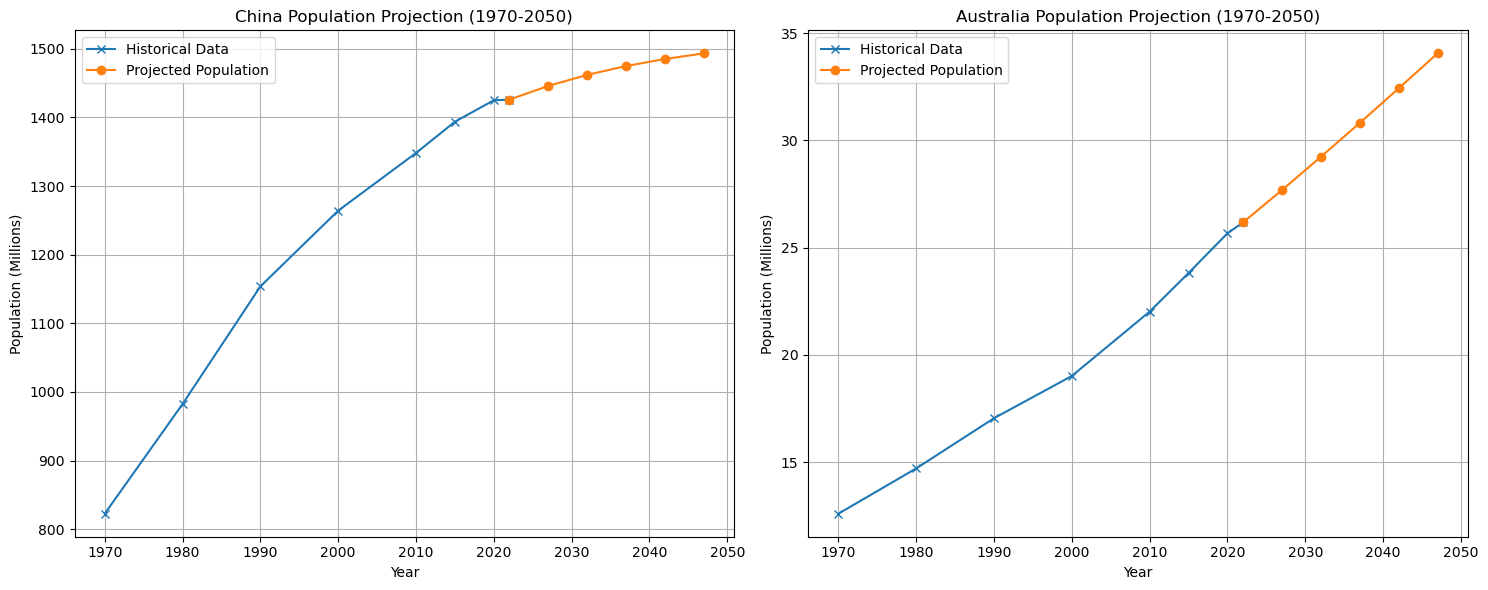

In [16]:
# Initialize figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot for China
process_and_plot_country("China", axs[0])

# Plot for Australia
process_and_plot_country("Australia", axs[1])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Exponential Decay Model

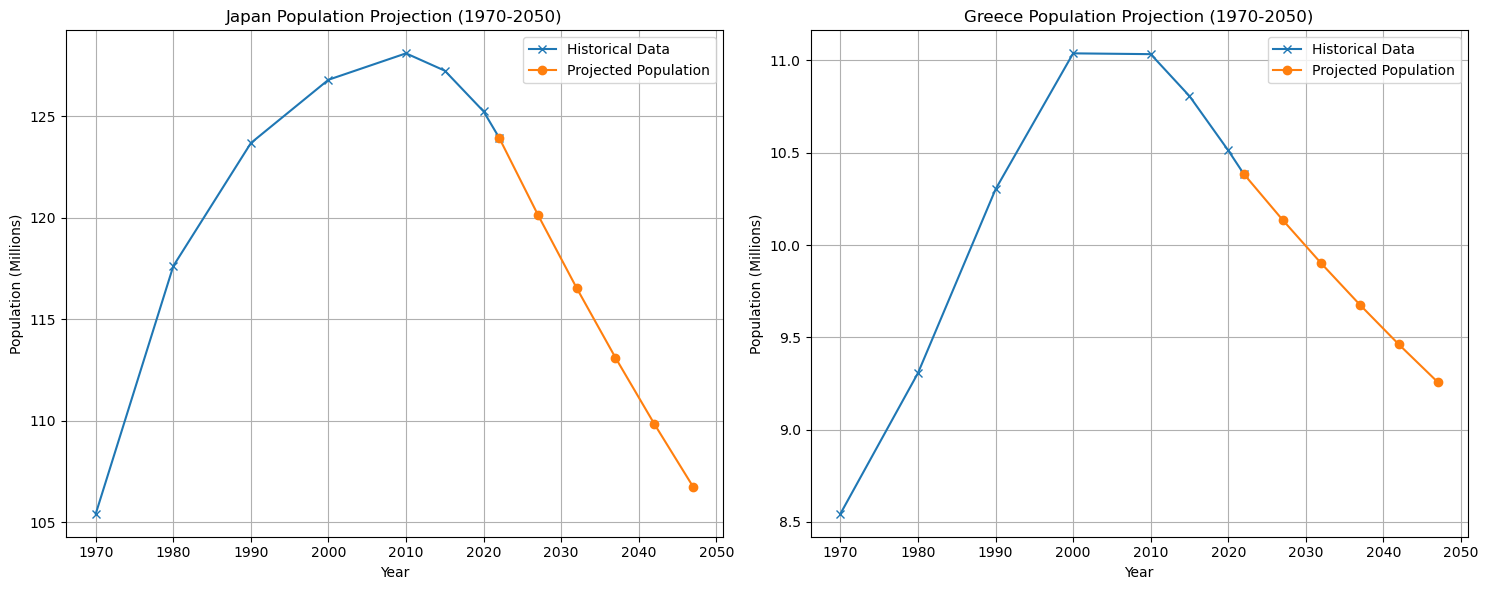

In [17]:
# Initialize figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot for China
process_and_plot_country("Japan", axs[0])

# Plot for Australia
process_and_plot_country("Greece", axs[1])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Polynomial Regression Model

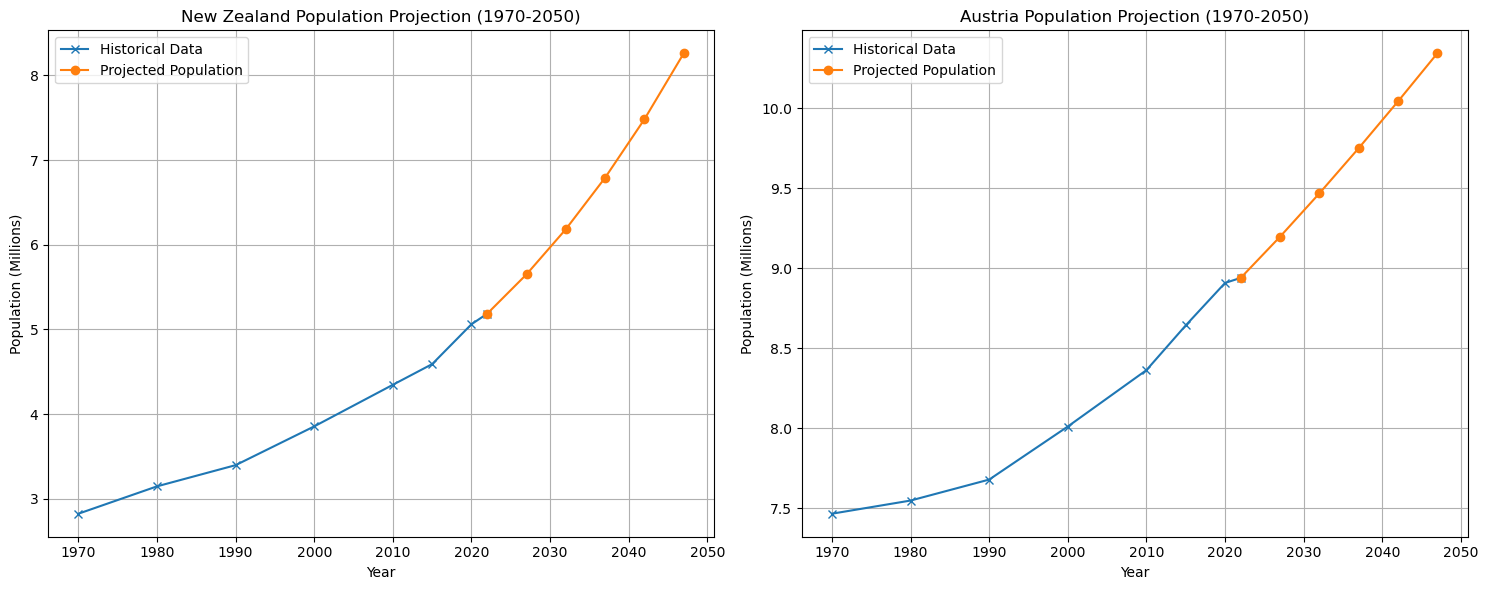

In [18]:
# Initialize figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot for China
process_and_plot_country("New Zealand", axs[0])

# Plot for Australia
process_and_plot_country("Austria", axs[1])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Future Improvement

- Can incorporate more data (immigration, climates, ...) into the original dataset, to deliver a more thorough analysis.

- Can use more complex models to do forecasting. 

- For the polynomial part, I intentionally select degree = 3 to avoid underfitting & overfitting, but it was not proven by data test. May design a algorithm to find the most suitable degree.


- ...